In [4]:
# Append 'src' directory to import modules from notebooks directory
#################################
import os,sys
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)
##################################

In [19]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 150)

import time
import os 
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim 
from src.models import VGG19
from src import Utils
from src.PatchMatch import PatchMatchOrig
import scipy
from scipy.optimize import minimize, rosen, rosen_der

Populating the interactive namespace from numpy and matplotlib


In [1007]:
def reconstruct_intermediates(pmab,feat_bb,pmba,feat_a):
    feat_a = feat_a.transpose(1,2,0)    
    feat_bb = feat_bb.transpose(1,2,0)
    return Utils.reconstruct_image(feat_bb,pmab) , Utils.reconstruct_image(feat_a,pmba)

def get_deconvoluted_feat(feat,feat_layer_num,iters=13):
    feat = cn_first(feat)
    feat = torch.from_numpy(feat)
    
    if feat_layer_num == 5:
        start_layer,end_layer = 21,29
        noise = np.random.uniform(size=(1,512,28*1,28*1),low=-1 , high=1) *2.
    elif feat_layer_num == 4:
        start_layer,end_layer = 12,20
        noise = np.random.uniform(size=(1,256,56*1,56*1),low=-1 , high=1) *2.
    elif feat_layer_num == 3:
        start_layer,end_layer = 7,11
        noise = np.random.uniform(size=(1,128,112*1,112*1),low=-1 , high=1) *2.
    elif feat_layer_num == 2:
        start_layer,end_layer = 2,6
        noise = np.random.uniform(size=(1,64,224*1,224*1),low=-1 , high=1) *2.
    else:
        print("Invalid layer number")
    
    noise = Variable(torch.from_numpy(noise).float())
    noise = noise.cuda()
    noise = nn.Parameter(noise.data.clone(),requires_grad=True)
#     optimizer = optim.LBFGS([noise],max_iter=50,lr=.05)
    optimizer = optim.Adam([noise],lr=1)

    if not next(model.model.parameters()).is_cuda:
        model.model = model.model.cuda()
    
    feat = Variable(feat).cuda()
    
    loss = nn.MSELoss(size_average=False)
    
    def closure():
        noise.data.clamp_(-1, 1)
        optimizer.zero_grad()
        output = model.forward_subnet(input_tensor=noise,start_layer=start_layer,end_layer=end_layer)
        loss_valu = loss(output,feat)
        loss_valu.backward()
        loss_hist.append(loss_valu.data.cpu().numpy())
        return loss_valu

    loss_hist = []
    for i in range(iters):
        pass
        optimizer.zero_grad()
        if i%500 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr']/5 
                print(param_group['lr'])
        optimizer.step(closure)

        output = model.forward_subnet(input_tensor=noise,start_layer=start_layer,end_layer=end_layer)
        

        loss_valu = output - feat
        abso = torch.norm(loss_valu)
        sqr = abso ** 2
        sqr.backward()
        optimizer.step()
        noise.data.clamp_(0, 1)

#         loss_valu = loss(output,feat)
#         loss_valu.backward()
#         optimizer.step()
#         loss_hist.append(loss_valu.cpu().data.numpy())
#         loss_hist.append(loss_valu.cpu().data.numpy())
        loss_hist.append(sqr.cpu().data.numpy())

#         optimizer.step(closure)

    def optimize_scipy(noise):
        noise = noise.cpu().data.numpy()
        
        def eval_loss(x0):
#             noise = noise.cpu().data.numpy()
            
            t = Variable(torch.from_numpy(x0.reshape(noise.shape)).float())
            t = t.cuda()
            t = nn.Parameter(t.data.clone(),requires_grad=True)
        
        
            output = model.forward_subnet(input_tensor=t,start_layer=start_layer,end_layer=end_layer)
            loss_valu = output - feat
            abso = torch.norm(loss_valu)
            sqr = abso ** 2
            sqr.backward()
#             print(sqr)
            return (sqr.cpu().data.numpy().astype(np.float64)[0] ,t.grad.data.cpu().numpy().astype(np.float64).flatten())
        
        def eval_grad(x1):
            print(type(x1))
            sqr.backward()
            print(sqr.grad())
            
        scipy.optimize.fmin_l_bfgs_b(eval_loss, noise.flatten(),iprint=20,maxfun=1000)
            
#     optimize_scipy(noise)
        


    pylab.rcParams['figure.figsize'] = (10, 10)
    plt.plot(loss_hist)
    plt.show()
#     noise.clamp(0,1)
    noise_cpu = noise.cpu().data.squeeze().numpy()
    del feat 
    del noise
    return cn_last(noise_cpu)

def blend_features(feat_a, recon_feat_bb, alpha=0.8, tau=0.05, k=300., use_sigmoid=False):
    def sigmoid(x):
        return 1 / (1. + np.exp(-x))
    
    def clip_at_threshold(neuron_mag_a, threshold):
        neuron_mag_a[neuron_mag_a < .05] = 0 
        return neuron_mag_a
    norm_feat_a = feat_a

    neuron_mag_a = (norm_feat_a - norm_feat_a.min(axis=(2),keepdims=True))/(norm_feat_a.max(axis=(2),keepdims=True)-norm_feat_a.min(axis=(2),keepdims=True))
    neuron_mag_a = clip_at_threshold(neuron_mag_a,0)

    neuron_mag_a = sigmoid(k*(neuron_mag_a - tau)) 
#     neuron_mag_a = clip_at_threshold(neuron_mag_a,0)

    weight_a = alpha*neuron_mag_a
    feat_aa = np.multiply(feat_a, weight_a) + np.multiply(recon_feat_bb, (1. - weight_a))
    return feat_aa

def normalize_feat_map(feat_map):
    """
    Normalize the feature map along the channels dimension
    
    feat_map is a numpy array with channels along the 2nd dimension
    """

    return feat_map/np.linalg.norm(feat_map,ord=None,axis=(2),keepdims=True)

def cn_last(th_array):
    return th_array.transpose(1,2,0)
    
def cn_first(th_array):
    return th_array.transpose(2,0,1)


def upsample_nnf(nnf,size):
    
    temp = np.zeros((nnf.shape[0],nnf.shape[1],3))

    for y in range(nnf.shape[0]):
        for x in range(nnf.shape[1]):
            temp[y][x] = [nnf[y][x][0],nnf[y][x][1],0]

    
    
    img = np.zeros(shape=(size,size,2),dtype=np.int)
    small_size = nnf.shape[0]
    aw_ratio = ((size)//small_size)
    ah_ratio = ((size)//small_size)
    
    temp = cv2.resize(temp, None, fx=aw_ratio, fy=aw_ratio, interpolation= cv2.INTER_NEAREST)

    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):

            pos = temp[i,j]
            img[i,j] = pos[0]*aw_ratio , pos[1]*ah_ratio
                    
    return img

# def upsample_nnf(nnf,size):
    
    
#     img = np.zeros(shape=(size,size,2),dtype=np.int)
#     small_size = nnf.shape[0]
#     aw_ratio = ((size)//small_size)
#     ah_ratio = ((size)//small_size)
    
#     for i in range(small_size):
#         for j in range(small_size):

#             pos = nnf[i,j]
#             img[i*ah_ratio:(i+1)*ah_ratio,j*aw_ratio:(j+1)*aw_ratio] = pos[0]*aw_ratio , pos[1]*ah_ratio
                    
#     return img




# def upsample_nnf(nnf,size):
#     nnf_batch = np.expand_dims(nnf.transpose(2,0,1),axis=0)
#     nnf_var = Variable(torch.from_numpy(nnf_batch).float())
#     upsampler = nn.UpsamplingNearest2d(size=(size,size))
#     upsampled_nnf_var = upsampler(nnf_var)
#     upsampled_nnf = np.squeeze(upsampled_nnf_var.data.numpy(),axis=0)
#     return upsampled_nnf.astype(np.int32).transpose(1,2,0)



def reconstruct_avg(nnf,img,patch_size=5):
    
    final = np.zeros_like(img)
    print(final.shape)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            dx0 = dy0 = patch_size // 2
            dx1 = dy1 = patch_size // 2 + 1
            dx0 = min(j, dx0)
            dx1 = min(img.shape[0] - j, dx1)
            dy0 = min(i, dy0)
            dy1 = min(img.shape[1] - i,  dy1)
            
            patch = nnf[i - dy0:i + dy1, j - dx0:j + dx1]
            
            lookups = np.zeros(shape=(patch.shape[0],patch.shape[1],3),dtype=np.float32)
            
            for ay in range(patch.shape[0]):
                for ax in range(patch.shape[1]):
                    x,y = patch[ay,ax]
                    lookups[ay,ax] = img[y,x]
            
            if lookups.size > 0 :
                value = np.average(lookups,axis=(0,1))
                final[i,j] = value
                    
        
    return final

## Defining the model from custom model class
The model class gives some extra functionality

In [7]:
model = VGG19()
model.model = model.model.cpu()
model.model

FeatureExtractor (
  (conv_1_1__0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1__1): ReLU ()
  (conv_1_2__2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2__3): ReLU ()
  (pool_1__4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2_1__5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1__6): ReLU ()
  (conv_2_2__7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2__8): ReLU ()
  (pool_2__9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3_1__10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1__11): ReLU ()
  (conv_3_2__12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2__13): ReLU ()
  (conv_3_3__14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3__15): ReLU ()
  (conv_3_4__16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [1008]:
model.model = model.model.cpu()

### Input Image Paths

In [1009]:
imga_path = '../data/external/mona.png'
imgbb_path = '../data/external/ava.jpg'

In [1010]:
imga = Utils.load_image(img_path=imga_path,to_array=True,to_variable=True)
imgbb = Utils.load_image(img_path=imgbb_path,to_array=True,to_variable=True)

In [1011]:
feat5a = model.get_features_for_layer(img_tensor=imga,layer_num=29)
feat5bb = model.get_features_for_layer(img_tensor=imgbb,layer_num=29)

In [1012]:
# feat1_norm = feat1/(feat1.max()-feat1.min())
# feat2_norm = feat2/(feat2.max() - feat2.min() )

# feat1_norm = feat1/(feat1.max())
# feat2_norm = feat2/(feat2.max() )

# feata_norm = (feata - np.mean(feata))/(np.std(feata))
# featbb_norm = (featbb - np.mean(featbb))/(np.std(featbb))

# feata_min = feata.min(axis=(0),keepdims=True)
# feata_max = feata.max(axis=(0),keepdims=True)

# featbb_min = featbb.min(axis=(0),keepdims=True)
# featbb_max = featbb.max(axis=(0),keepdims=True)

# feata_norm = (feata - feata_min)/(feata_max-feata_min)
# featbb_norm = (featbb - featbb_min)/(featbb_max-featbb_min)


feat5a_norm = normalize_feat_map(feat5a)
feat5bb_norm = normalize_feat_map(feat5bb)



In [1013]:
pm5ab = PatchMatchOrig(feat5a_norm,feat5a_norm,feat5bb_norm,feat5bb_norm, 3)
# plt.imshow(pm5ab.visualize())
pm5ab.propagate(iters=5,rand_search_radius=6)
# plt.imshow(pm5ab.visualize())

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


In [1014]:
imga_raw = Utils.load_image(img_path=imga_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
imgbb_raw = Utils.load_image(img_path=imgbb_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
imga_raw.shape

(224, 224, 3)

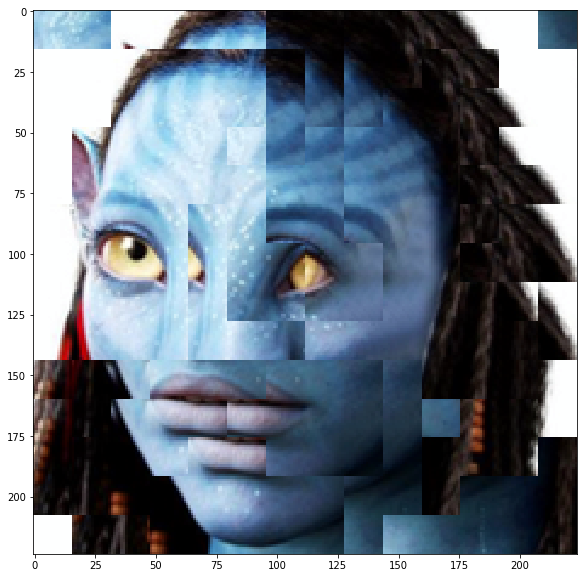

In [1015]:
recon = Utils.reconstruct_image(imgbb_raw,pm=pm5ab)
plt.imshow(Utils.deprocess_image(recon))

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


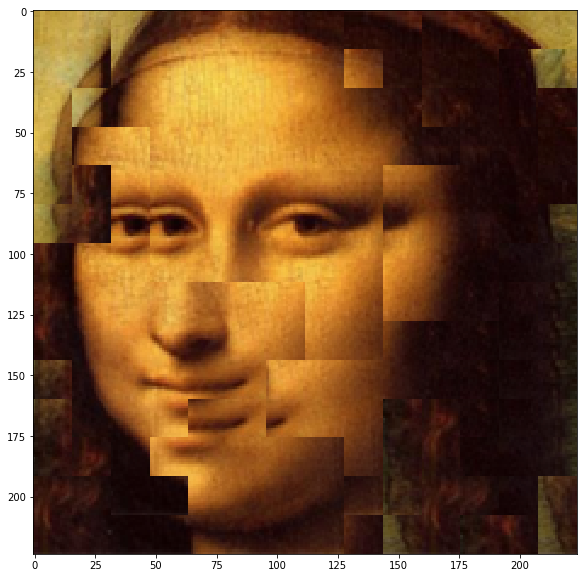

In [1016]:
pm5ba = PatchMatchOrig(feat5bb_norm,feat5bb_norm,feat5a_norm,feat5a_norm,3)
# plt.imshow(pm5ba.visualize())
pm5ba.propagate(iters=5,rand_search_radius=6)
# plt.imshow(pm5ba.visualize())
recon = Utils.reconstruct_image(imga_raw,pm=pm5ba)
plt.imshow(Utils.deprocess_image(recon))

In [1017]:
warped_feat5bb = Utils.reconstruct_image(feat5bb,pm=pm5ab)
warped_feat5a = Utils.reconstruct_image(feat5a,pm=pm5ba)

feat5a.shape

(14, 14, 512)

0.2
0.04
0.008
0.0016
0.00032


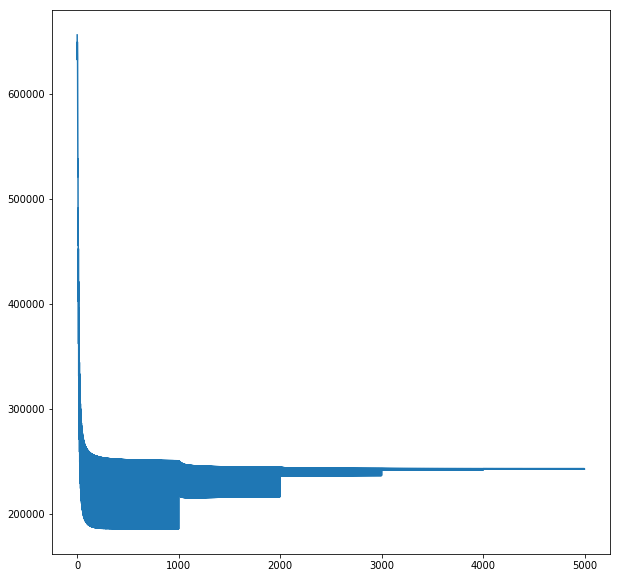

0.2
0.04
0.008
0.0016
0.00032


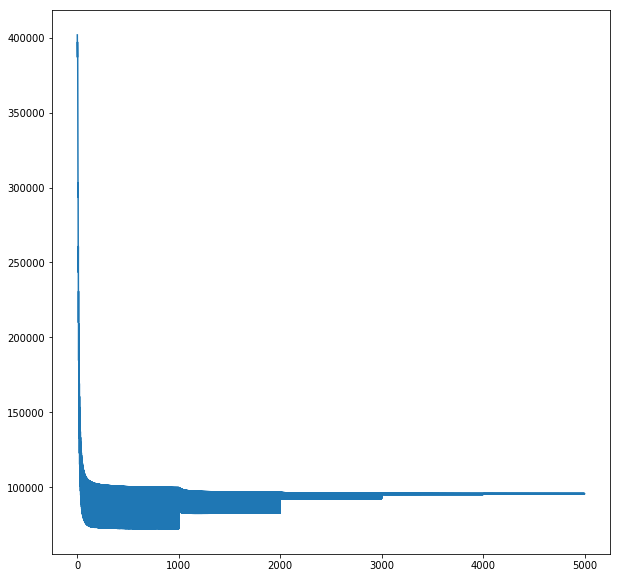

In [1018]:
r4_bb = get_deconvoluted_feat(warped_feat5bb,5,iters=2500)
r4_a = get_deconvoluted_feat(warped_feat5a,5,iters=2500)

In [1019]:
model.model = model.model.cpu()
feat4a = model.get_features_for_layer(imga,layer_num=20)
feat4bb = model.get_features_for_layer(imgbb,layer_num=20)

In [1020]:
feat4aa = blend_features(feat4a,r4_bb,alpha=.7)
feat4b =  blend_features(feat4bb,r4_a,alpha=.7)

# feat4b = r4_a
# feat4aa = r4_bb

In [1021]:
feat4a_norm = normalize_feat_map(feat4a)
feat4bb_norm = normalize_feat_map(feat4bb)

feat4aa_norm = normalize_feat_map(feat4aa)
feat4b_norm = normalize_feat_map(feat4b)

In [1022]:
model.model = model.model.cpu()

In [1023]:
pm4ab = PatchMatchOrig(feat4a_norm,feat4aa_norm,feat4b_norm,feat4bb_norm, 3)
pm4ab.nnf = upsample_nnf(nnf=pm5ba.nnf,size=28)

pm4ab.propagate(iters=5,rand_search_radius=6)

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


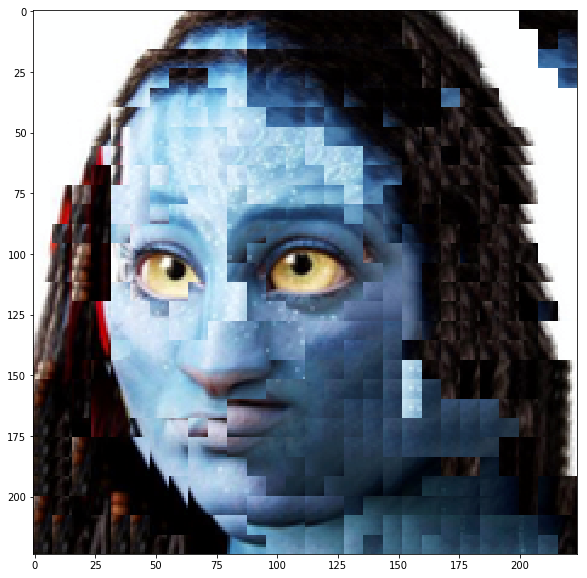

In [1024]:
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imgbb_raw,pm=pm4ab)))

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


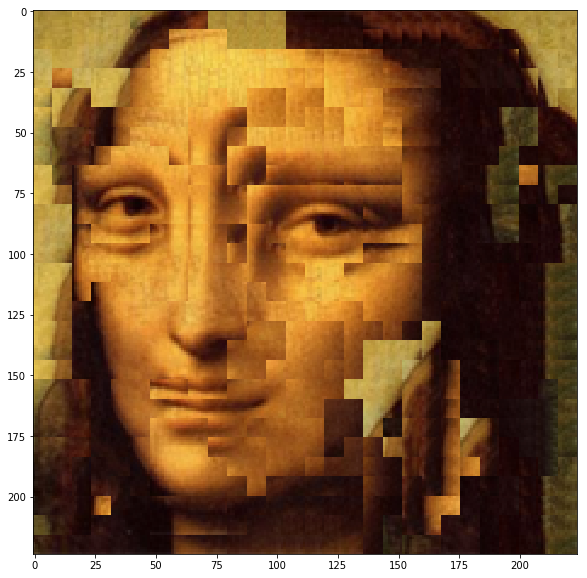

In [1025]:
pm4ba = PatchMatchOrig(feat4bb_norm,feat4b_norm,feat4aa_norm,feat4a_norm, 3)
pm4ba.nnf = upsample_nnf(nnf=pm5ba.nnf,size=28)

pm4ba.propagate(iters=5,rand_search_radius=6)
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imga_raw,pm=pm4ba)))

0.2
0.04
0.008
0.0016
0.00032


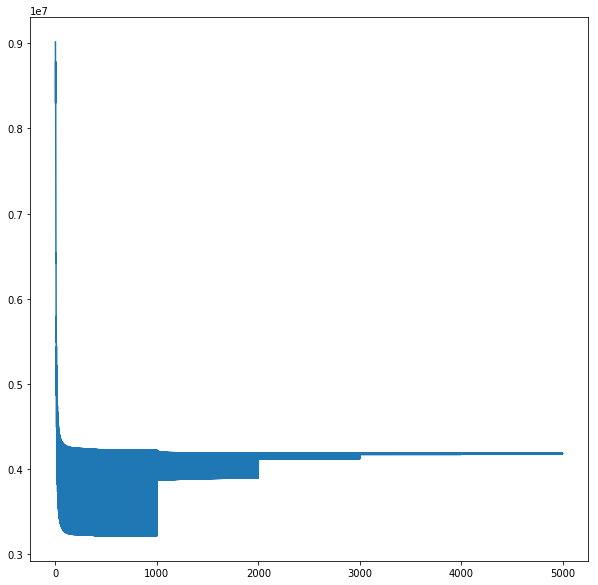

0.2
0.04
0.008
0.0016
0.00032


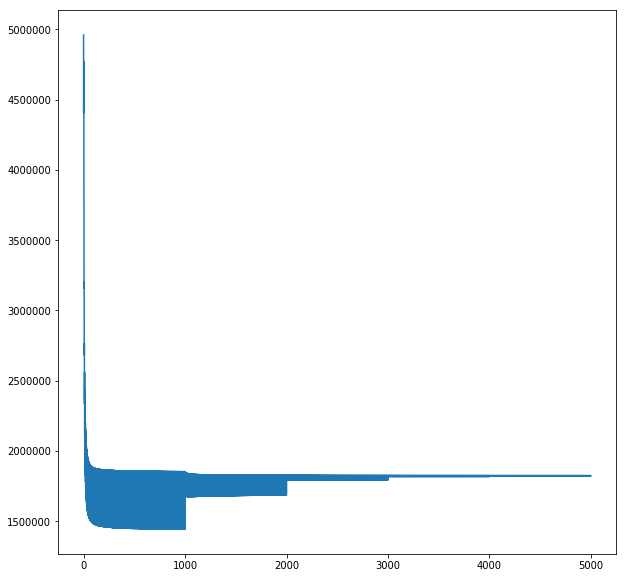

In [1026]:
warped_feat4bb = Utils.reconstruct_image(feat4bb,pm=pm4ab)
warped_feat4a = Utils.reconstruct_image(feat4a,pm=pm4ba)

r3_bb = get_deconvoluted_feat(warped_feat4bb,4,iters=2500)
r3_a = get_deconvoluted_feat(warped_feat4a,4,iters=2500)

In [1027]:
model.model = model.model.cpu()
feat3a = model.get_features_for_layer(imga,layer_num=11)
feat3bb = model.get_features_for_layer(imgbb,layer_num=11)

In [1028]:
feat3aa = blend_features(feat3a,r3_bb,alpha=.7,use_sigmoid=False)
feat3b =  blend_features(feat3bb,r3_a,alpha=.7,use_sigmoid=False)

feat3aa = r3_bb
feat3b = r3_a



In [1029]:
feat3a_norm = normalize_feat_map(feat3a)
feat3bb_norm = normalize_feat_map(feat3bb)

feat3aa_norm = normalize_feat_map(feat3aa)
feat3b_norm = normalize_feat_map(feat3b)

In [1030]:
pm3ab = PatchMatchOrig(feat3a_norm,feat3aa_norm,feat3b_norm,feat3bb_norm, 3)
pm3ab.nnf = upsample_nnf(nnf=pm4ab.nnf,size=56)

pm3ab.propagate(iters=5,rand_search_radius=4)

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


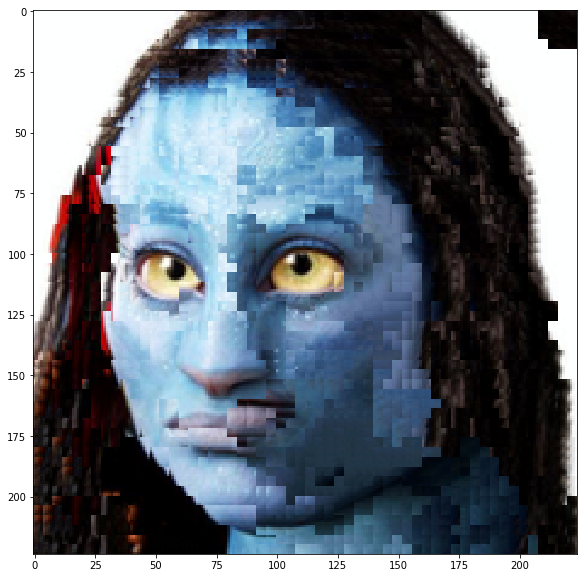

In [1031]:
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imgbb_raw,pm=pm3ab)))

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


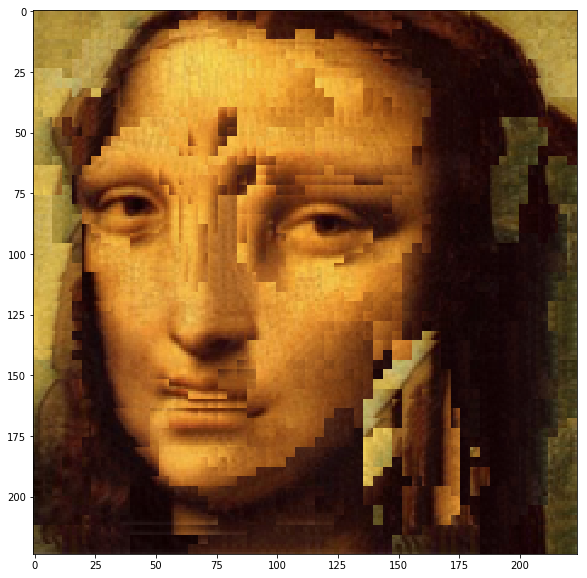

In [1032]:
pm3ba = PatchMatchOrig(feat3bb_norm,feat3b_norm,feat3aa_norm,feat3a_norm, 5)
pm3ba.nnf = upsample_nnf(nnf=pm4ba.nnf,size=56)

pm3ba.propagate(iters=5,rand_search_radius=4)
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imga_raw,pm=pm3ba)))

0.2
0.04
0.008
0.0016
0.00032


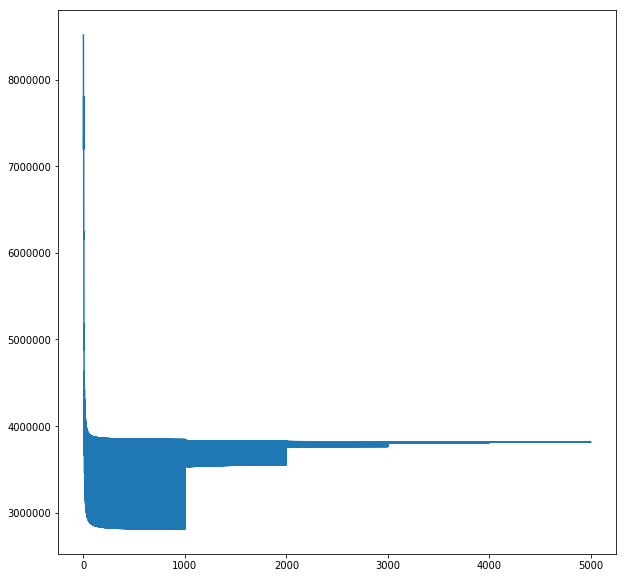

0.2
0.04
0.008
0.0016
0.00032


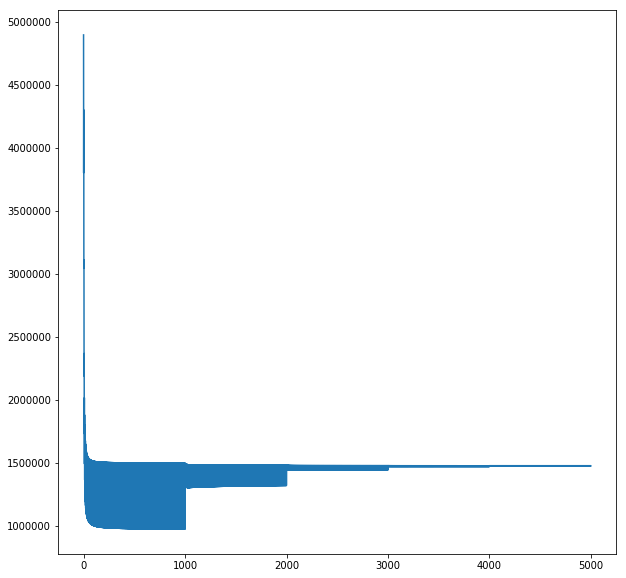

In [1033]:
warped_feat3bb = Utils.reconstruct_image(feat3bb,pm=pm3ab)
warped_feat3a = Utils.reconstruct_image(feat3a,pm=pm3ba)

r2_bb = get_deconvoluted_feat(warped_feat3bb,3,iters=2500)
r2_a = get_deconvoluted_feat(warped_feat3a,3,iters=2500)

In [1034]:
model.model = model.model.cpu()
feat2a = model.get_features_for_layer(imga,layer_num=6)
feat2bb = model.get_features_for_layer(imgbb,layer_num=6)

In [1035]:
feat2aa = blend_features(feat2a,r2_bb,.6,use_sigmoid=False)
feat2b = blend_features(feat2bb,r2_a,.6,use_sigmoid=False)

# feat2aa = r2_bb
# feat2b = r2_a

In [1036]:
feat2a_norm = normalize_feat_map(feat2a)
feat2bb_norm = normalize_feat_map(feat2bb)

feat2aa_norm = normalize_feat_map(feat2aa)
feat2b_norm = normalize_feat_map(feat2b)

In [1037]:
pm2ab = PatchMatchOrig(feat2a_norm,feat2aa_norm,feat2b_norm,feat2bb_norm, 5)
pm2ab.nnf = upsample_nnf(nnf=pm3ab.nnf,size=112)

pm2ab.propagate(iters=5,rand_search_radius=4)

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


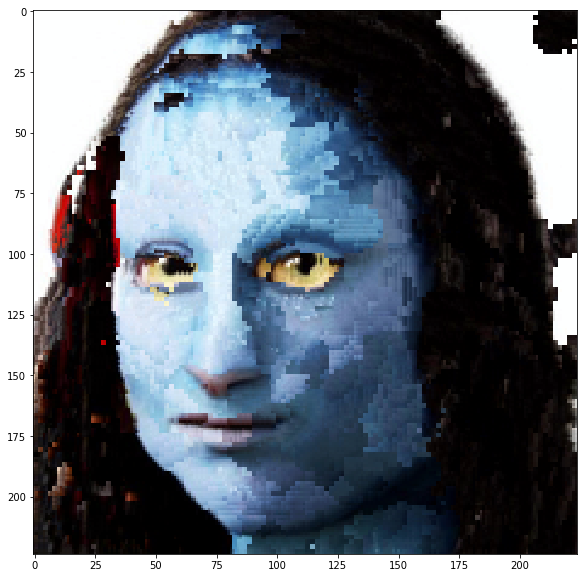

In [1038]:
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imgbb_raw,pm=pm2ab)))

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


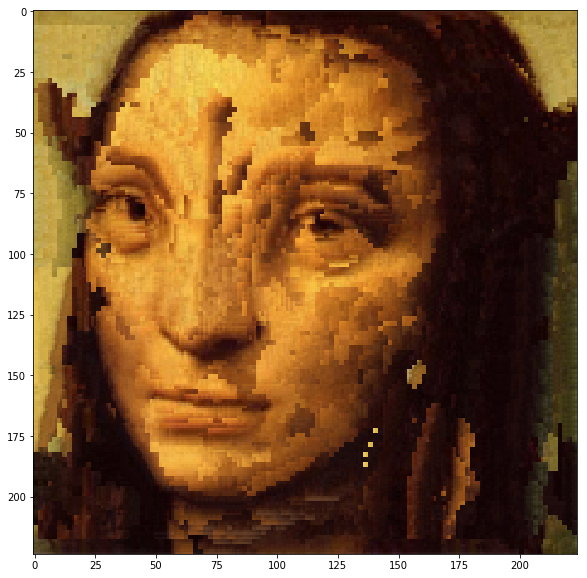

In [1039]:
pm2ba = PatchMatchOrig(feat2bb_norm,feat2b_norm,feat2aa_norm,feat2a_norm, 5)
pm2ba.nnf = upsample_nnf(nnf=pm3ba.nnf,size=112)

pm2ba.propagate(iters=5,rand_search_radius=4)
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imga_raw,pm=pm2ba)))

0.2
0.04
0.008
0.0016
0.00032


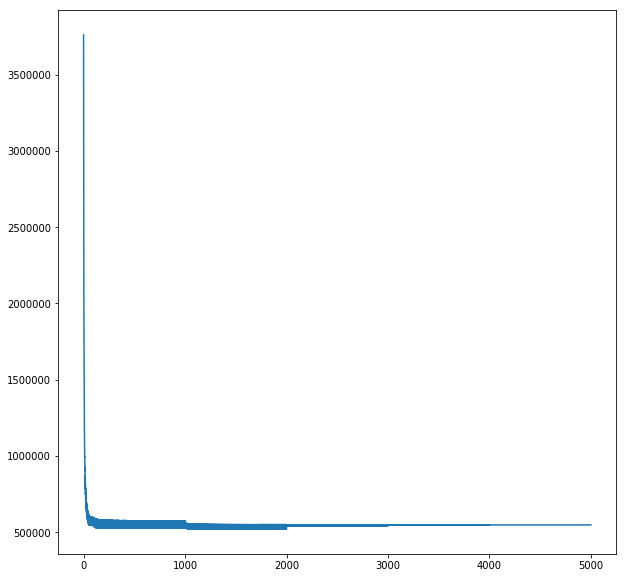

0.2
0.04
0.008
0.0016
0.00032


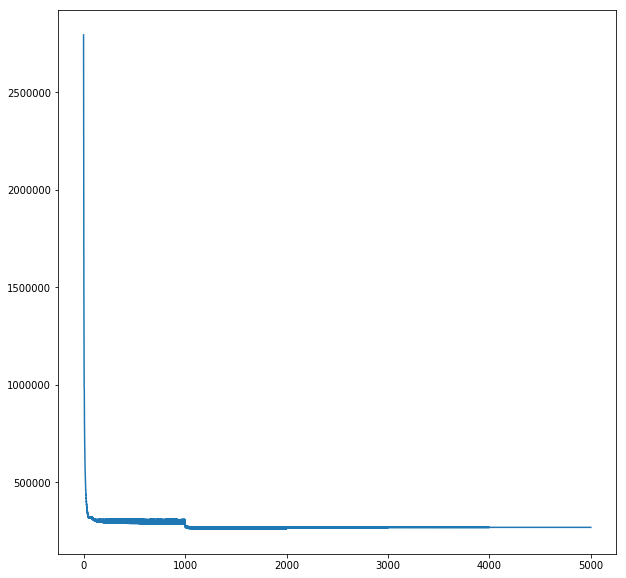

In [1040]:
warped_feat2bb = Utils.reconstruct_image(feat2bb,pm=pm2ab)
warped_feat2a = Utils.reconstruct_image(feat2a,pm=pm2ba)

r1_bb = get_deconvoluted_feat(warped_feat2bb,2,iters=2500)
r1_a = get_deconvoluted_feat(warped_feat2a,2,iters=2500)

In [1041]:
model.model = model.model.cpu()
feat1a = model.get_features_for_layer(imga,layer_num=1)
feat1bb = model.get_features_for_layer(imgbb,layer_num=1)

In [1042]:
feat1aa = blend_features(feat1a,r1_bb,alpha=.1)
feat1b = blend_features(feat1bb,r1_a,alpha=.1)

# feat1aa = r1_bb
# feat1b = r1_a

In [1043]:
feat1a_norm = normalize_feat_map(feat1a)
feat1bb_norm = normalize_feat_map(feat1bb)

feat1aa_norm = normalize_feat_map(feat1aa)
feat1b_norm = normalize_feat_map(feat1b)

In [1044]:
pm1ab = PatchMatchOrig(feat1a_norm,feat1aa_norm,feat1b_norm,feat1bb_norm, 5)
pm1ab.nnf = upsample_nnf(nnf=pm2ab.nnf,size=224)

pm1ab.propagate(iters=5,rand_search_radius=4)

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


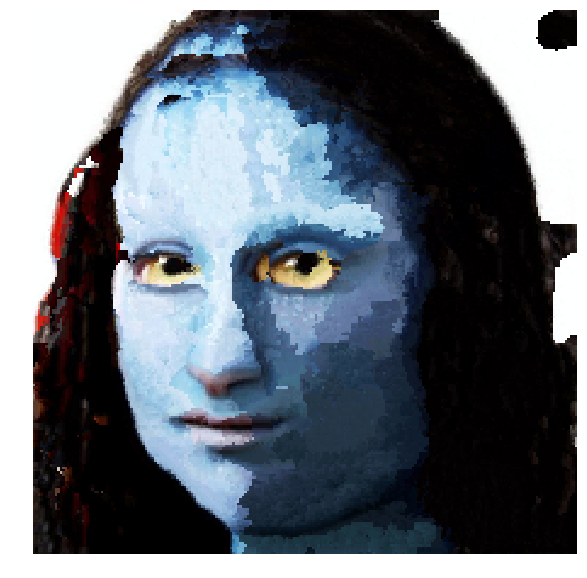

In [1045]:
plt.axis('off')
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imgbb_raw,pm=pm1ab)))

In [1046]:
pm1ba = PatchMatchOrig(feat1bb_norm,feat1b_norm,feat1aa_norm,feat1a_norm, 5)
pm1ba.nnf = upsample_nnf(nnf=pm2ba.nnf,size=224)

pm1ba.propagate(iters=5,rand_search_radius=4)

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


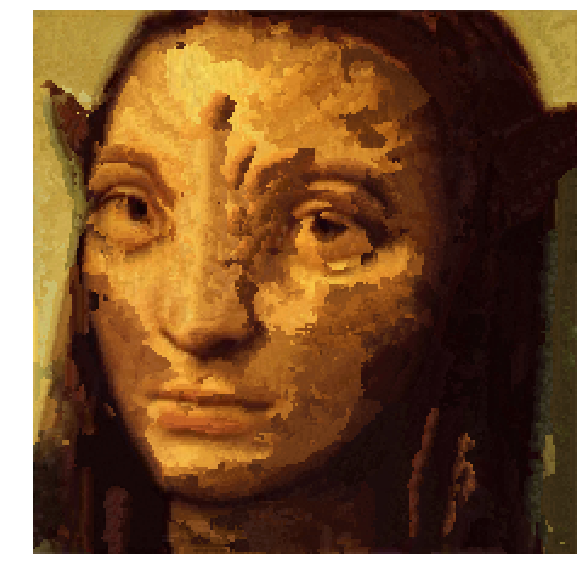

In [1047]:
plt.axis('off')
plt.imshow(Utils.deprocess_image(Utils.reconstruct_image(img_a=imga_raw,pm=pm1ba)))

In [1048]:
# feat1a.shape

(224, 224, 3)


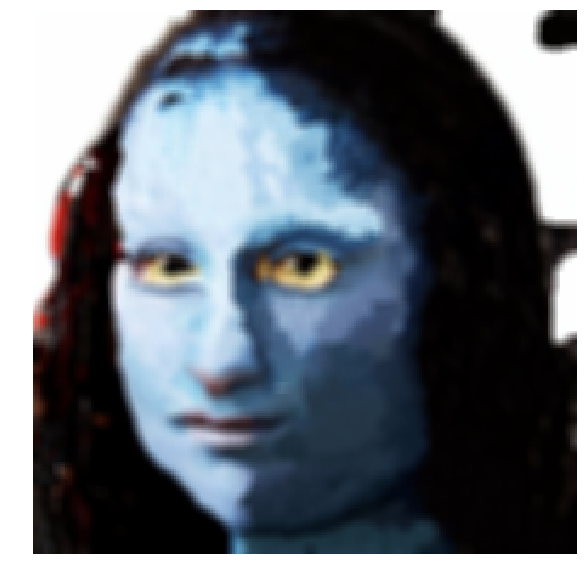

In [1049]:
ups = upsample_nnf(nnf=pm1ab.nnf,size=224)
plt.axis('off')
plt.imshow(np.clip(Utils.deprocess_image(reconstruct_avg(ups,imgbb_raw,patch_size=5)),0,1))

(224, 224, 3)


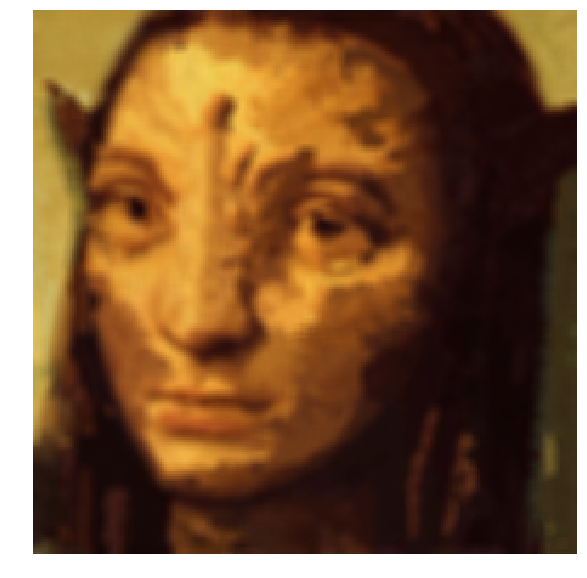

In [1050]:
ups = upsample_nnf(nnf=pm1ba.nnf,size=224)
plt.axis('off')
plt.imshow(np.clip(Utils.deprocess_image(reconstruct_avg(ups,imga_raw,patch_size=5)),0,1))

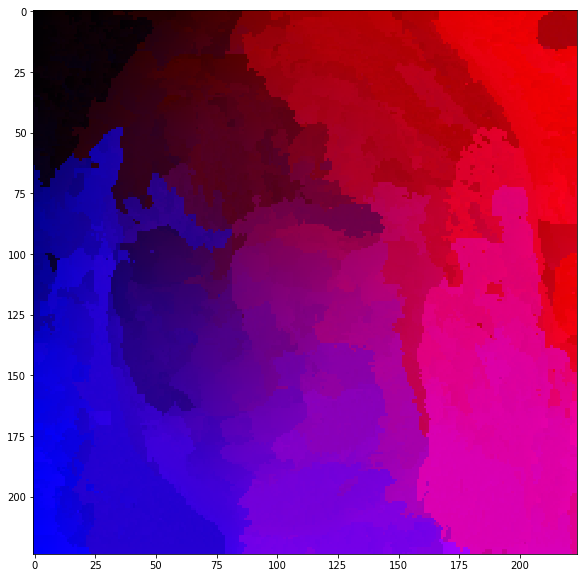

In [1051]:
plt.imshow(pm1ab.visualize())

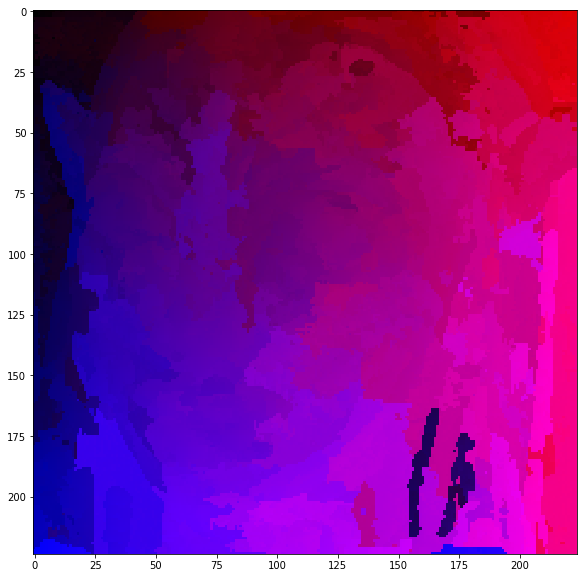

In [1052]:
plt.imshow(pm1ba.visualize())